In [1]:
library(tidyverse)
library(stringr)
library(magrittr)

source("../R/utils.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract



### Load the averages of conservation tracks in different windows

In [2]:
files <- list.files("../clean_data/annotations", pattern="*.bed$", full.names=TRUE)

In [3]:
window_avgs_long <- lapply(files, function(f) {
    read.table(f, header=FALSE) %>%
        .[1:4] %>%
        setNames(c("chrom", "start", "end", "value")) %>%
        mutate(track=str_replace(basename(f), ".bed", ""))
}) %>%
    bind_rows %>%
    rename(pos=end) %>% 
    select(-start)

In [4]:
window_avgs_wide <- spread(window_avgs_long, track, value)

### Load a subset of annotation tracks used by CADD

In [5]:
suppressMessages(
    cadd_wide <-
        load_annotations("../clean_data/annotations.tsv") %>%
        select(chrom, pos, bStatistic, priPhCons, priPhyloP, Consequence, AnnoType) %>% 
        rename(bval=bStatistic)
)

Warning message:
"673 parsing failures.
 row            col               expected  actual
2136 mapAbility35bp no trailing characters .5     
4607 mapAbility35bp no trailing characters .333333
5028 mapAbility35bp no trailing characters .5     
5379 mapAbility35bp no trailing characters .5     
5819 mapAbility35bp no trailing characters .5     
.... .............. ...................... .......
See problems(...) for more details.
"

In [6]:
cadd_long <- gather(cadd_wide, track, value, -c(chrom, pos, Consequence, AnnoType))

### Merge both tables

In [7]:
all_annots_wide <- inner_join(window_avgs_wide, cadd_wide)
all_annots_long <- bind_rows(window_avgs_long, cadd_long)

Joining, by = c("chrom", "pos")


# Plot distributions of window-based conservation values

In [8]:
plot_window_dist <- function(tr, df, lim=NULL) {
    p <- filter(df, str_detect(track, tr)) %>% 
        ggplot(aes(value, color=track, group=track)) +
            geom_density() +
            labs(title=tr)

    if (!is.null(lim)) {
        p + xlim(lim)
    } else{
        p
    }
}

In [9]:
options(repr.plot.width=10, repr.plot.height=3)

In [38]:
head(all_annots_wide) %>% select(starts_with("bval"))

bval__100000bp,bval__10000bp,bval__25000bp,bval__50000bp,bval
952.9395,958.0000,958.5330,957.1616,958
949.5297,956.7803,956.0167,954.3714,958
949.2357,956.4762,955.6517,954.0672,958
948.5645,955.7580,954.8288,953.3490,958
946.5280,953.3169,952.8757,950.5166,952
943.3367,947.4741,945.8735,944.6941,946


Warning message:
"Removed 719 rows containing non-finite values (stat_density)."

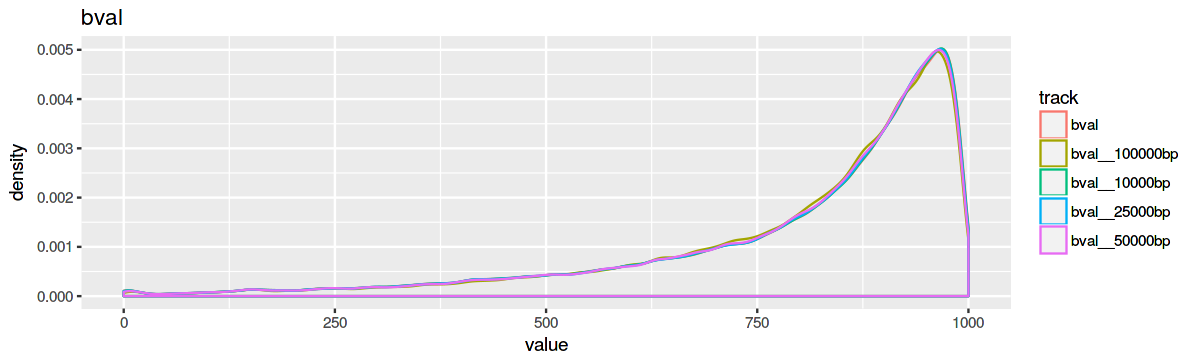

Warning message:
"Removed 1031074 rows containing non-finite values (stat_density)."

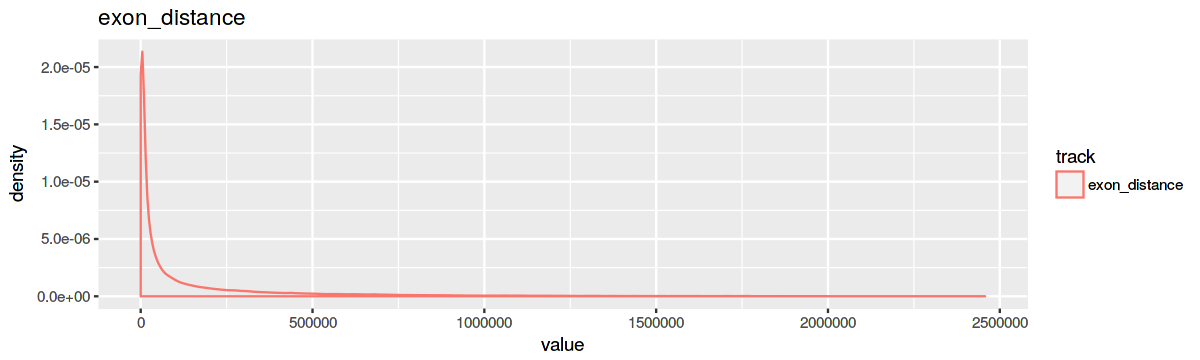

Warning message:
"Removed 975 rows containing non-finite values (stat_density)."

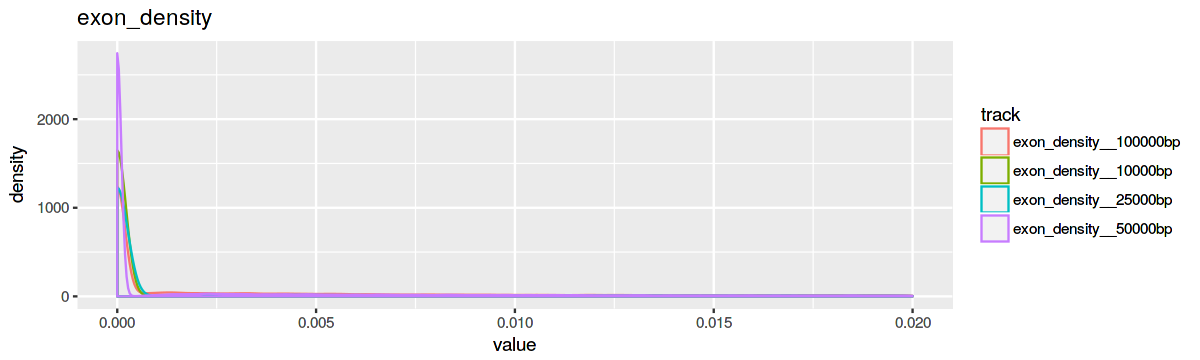

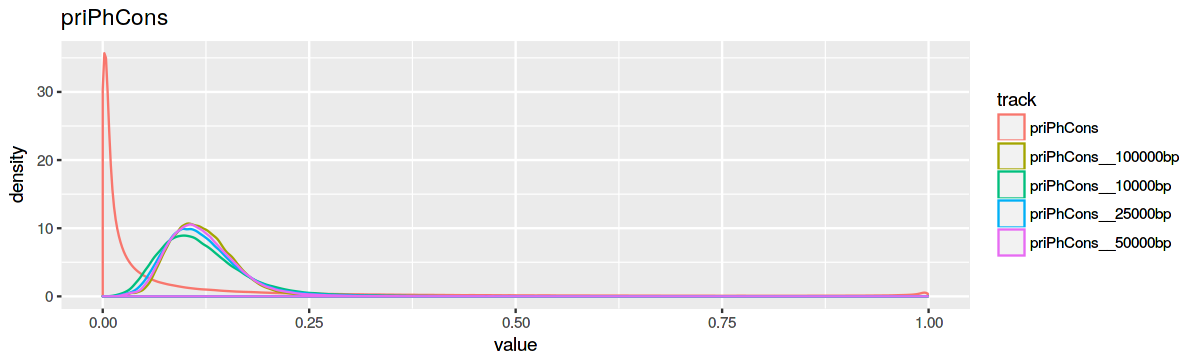

In [10]:
plot_window_dist("bval", all_annots_long)
plot_window_dist("exon_distance", all_annots_long)
plot_window_dist("exon_density", all_annots_long, c(0, 0.02))
plot_window_dist("priPhCons", all_annots_long)

<br><br><br><br><br>
# How to intersect conservation measures to get superneutral regions?

In [11]:
options(repr.plot.width=7, repr.plot.height=3)

### per SNP phastCons (< 1% probability is neutral, > 95% probability is conserved) -> B value

Warning message:
"Removed 2 rows containing non-finite values (stat_density)."Warning message:
"Removed 124 rows containing non-finite values (stat_density)."Warning message:
"Removed 283 rows containing non-finite values (stat_density)."

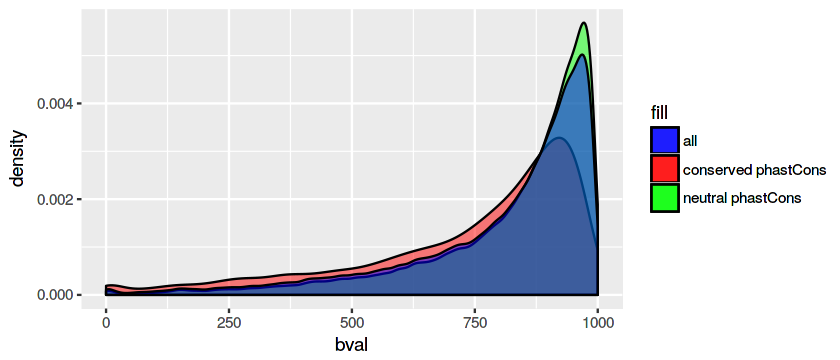

In [12]:
ggplot() +
    geom_density(aes(bval, fill="green"), data=filter(all_annots_wide, priPhCons > 0.95), alpha=1/2) +
    geom_density(aes(bval, fill="red"), data=filter(all_annots_wide, priPhCons < 0.01), alpha=1/2) +
    geom_density(aes(bval, fill="blue"), data=all_annots_wide, alpha=1/2) +
    scale_fill_manual(labels = c("all", "conserved phastCons", "neutral phastCons"),
                      values = c("blue", "red", "green"))

### average primatePhastCons in 100kb window -> B value

In [13]:
quantile(all_annots_wide$priPhCons__100000bp, probs=c(0.05, 0.95), na.rm=TRUE)

5%       95% 
0.0654160 0.1891252

Warning message:
"Removed 2 rows containing non-finite values (stat_density)."Warning message:
"Removed 71 rows containing non-finite values (stat_density)."Warning message:
"Removed 283 rows containing non-finite values (stat_density)."

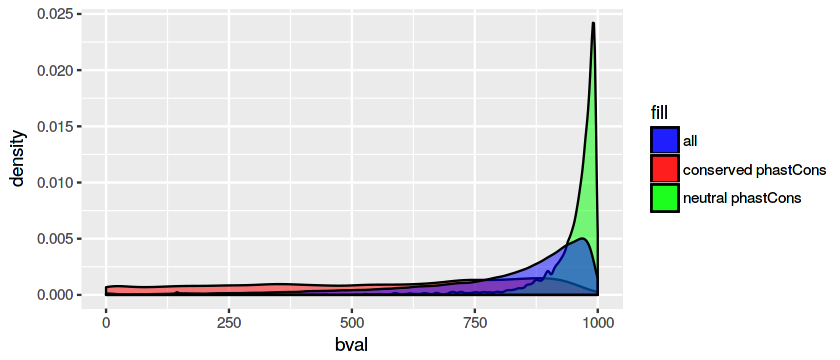

In [14]:
ggplot() +
    geom_density(aes(bval, fill="green"), data=filter(all_annots_wide, priPhCons__100000bp > 0.2), alpha=1/2) +
    geom_density(aes(bval, fill="red"),   data=filter(all_annots_wide, priPhCons__100000bp < 0.07), alpha=1/2) +
    geom_density(aes(bval, fill="blue"),  data=all_annots_wide, alpha=1/2) +
    scale_fill_manual(labels = c("all", "conserved phastCons", "neutral phastCons"),
                      values = c("blue", "red", "green"))

In [15]:
options(repr.plot.width=3, repr.plot.height=3)

Warning message:
"Removed 8 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 8 rows containing missing values (geom_point)."

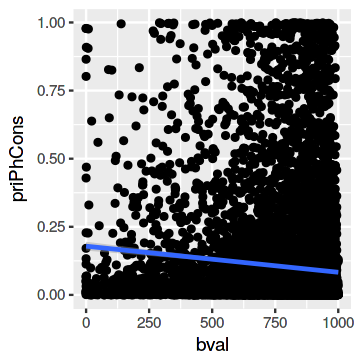

In [16]:
ggplot(sample_n(all_annots_wide, 10000), aes(x=bval, y=priPhCons)) +
    geom_point() +
    geom_smooth(method="lm")

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

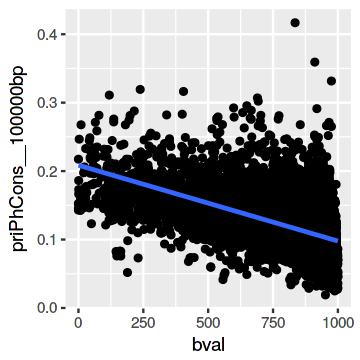

In [19]:
ggplot(sample_n(all_annots_wide, 10000), aes(x=bval, y=priPhCons__100000bp)) +
    geom_point() +
    geom_smooth(method="lm")

### Exon density -> B value

In [21]:
options(repr.plot.width=7, repr.plot.height=3)

Warning message:
"Removed 142 rows containing non-finite values (stat_density)."Warning message:
"Removed 283 rows containing non-finite values (stat_density)."

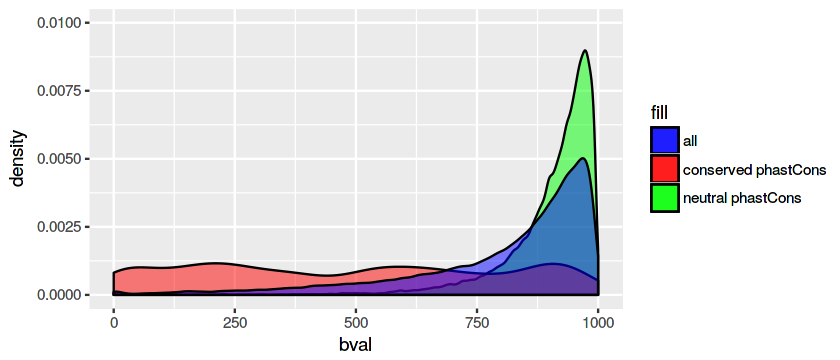

In [25]:
ggplot() +
    geom_density(aes(bval, fill="red"), data=filter(all_annots_wide, exon_density__100000bp == 0), alpha=1/2) +
    geom_density(aes(bval, fill="green"), data=filter(all_annots_wide, exon_density__100000bp > 0.2), alpha=1/2) +
    geom_density(aes(bval, fill="blue"), data=all_annots_wide, alpha=1/2) +
    scale_fill_manual(labels = c("all", "conserved phastCons", "neutral phastCons"),
                      values = c("blue", "red", "green")) +
    ylim(0, 0.01)

In [27]:
a <- window_avgs_long %>% filter(track == "bval__100000bp") %>% select(chrom, pos, a=value)

In [30]:
b <- read.table("../raw_data//archaic.bed.sorted.bvals.w100kb") %>% setNames(c("chrom", "start", "pos", "count", "bval", "q5", "q95"))

In [31]:
head(b)

chrom,start,pos,count,bval,q5,q95
1,847982,847983,81938,959.1149,934,970
1,853088,853089,76832,958.3916,934,970
1,853595,853596,76325,958.3144,934,970
1,854792,854793,75128,958.1283,934,970
1,858861,858862,71059,957.4485,934,970
1,867150,867151,62770,955.7910,934,970


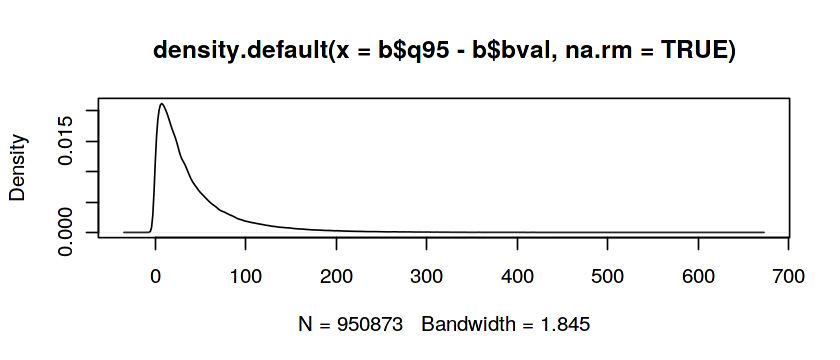

In [33]:
plot(density(b$q95-b$bval, na.rm=TRUE))

In [36]:
tmp <- sample_n(b, 10000)

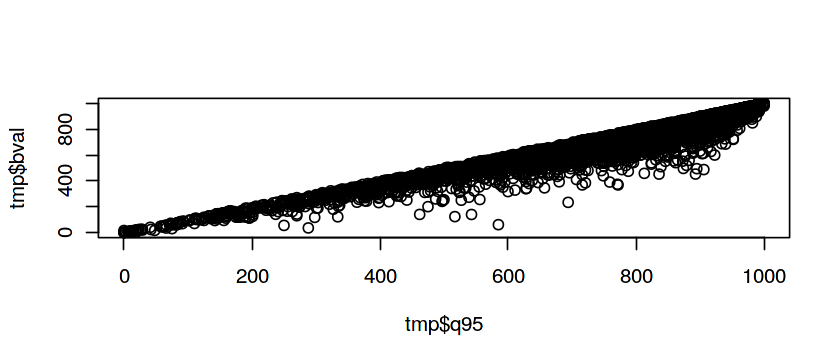

In [37]:
plot(tmp$q95, tmp$bval)

In [34]:
x <- inner_join(a, b)

Joining, by = c("chrom", "pos")


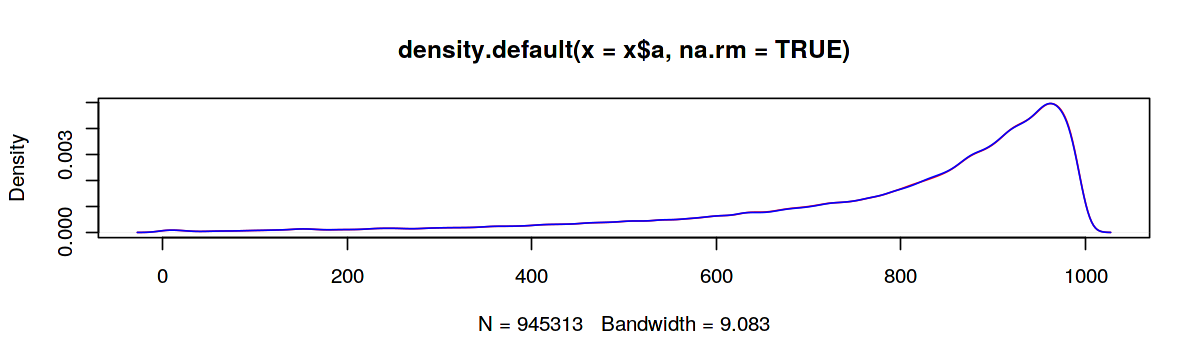

In [35]:
plot(density(x$a, na.rm=TRUE), col="red")
lines(density(x$b, na.rm=TRUE), col="blue")